In [1]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
import time

import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models

import HRNet
import utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('------------------------------------------------------------------')
print(device)
print('------------------------------------------------------------------')

------------------------------------------------------------------
cuda
------------------------------------------------------------------


In [3]:
# get the VGG19's structure except the full-connect layers
VGG = models.vgg19(pretrained=True).features
VGG.to(device)
print(VGG)
# only use VGG19 to extract features, we don't need to change it's parameters
for parameter in VGG.parameters():
    parameter.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [4]:
style_net = HRNet.HRNet()
style_net.to(device)
print(style_net)

HRNet(
  (pass1_1): BasicBlock(
    (relu): ReLU(inplace)
    (identity_block): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
      (3): ConvLayer(
        (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU()
      (6): ConvLayer(
        (conv): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (7): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (8): ReLU()
    )
    (shortcut): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
  )
  (pass1_2): BasicBlock(
    (relu

)


In [5]:
content_image = utils.load_image("./content.png", img_size=500)  # temporary/content.png
content_image = content_image.to(device)

style_image = utils.load_image("./style.png")  # temporary/style.png
style_image = style_image.to(device)

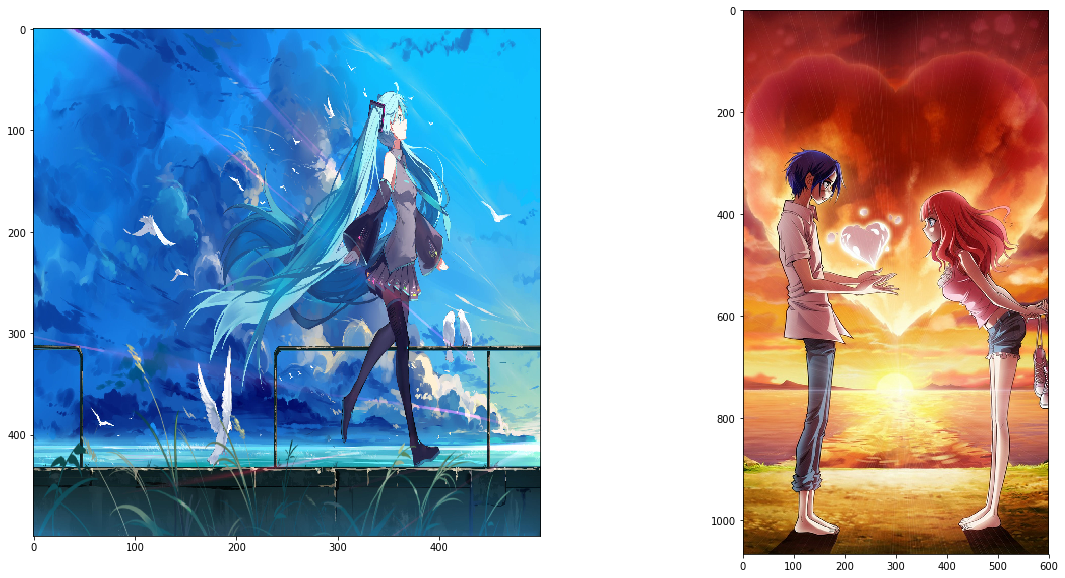

In [6]:
# display the raw images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(utils.im_convert(content_image))
ax2.imshow(utils.im_convert(style_image))
plt.show()

In [7]:
content_features = utils.get_features(content_image, VGG)
style_features   = utils.get_features(style_image, VGG)

style_gram_matrixs = {layer: utils.get_grim_matrix(style_features[layer]) for layer in style_features}

target = content_image.clone().requires_grad_(True).to(device)

In [8]:
# try to give fore con_layers more weight so that can get more detail in output iamge
style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = 150
style_weight = 1

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
steps = 1000

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []
output_image = content_image

D:\PythonLibrary\Anaconda\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
D:\PythonLibrary\Anaconda\lib\site-packages\torch\nn\functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


After 0 criterions:
Total loss:  4440.79248046875
Content loss:  14.232255935668945
Style loss:  2305.9541015625


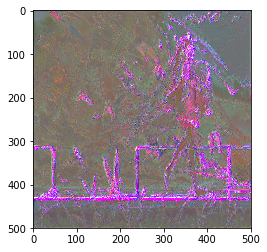

After 100 criterions:
Total loss:  746.4178466796875
Content loss:  2.699476718902588
Style loss:  341.496337890625


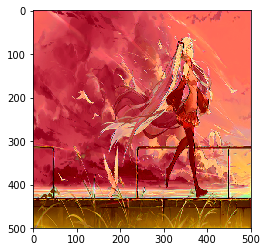

After 200 criterions:
Total loss:  624.0538940429688
Content loss:  2.070772409439087
Style loss:  313.4380187988281


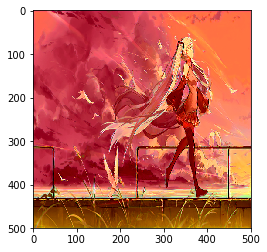

After 300 criterions:
Total loss:  557.6771240234375
Content loss:  1.7072348594665527
Style loss:  301.59185791015625


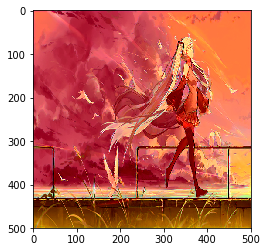

After 400 criterions:
Total loss:  535.4791870117188
Content loss:  1.64113450050354
Style loss:  289.3089904785156


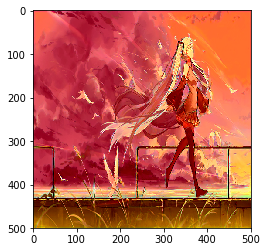

After 500 criterions:
Total loss:  500.72076416015625
Content loss:  1.4524409770965576
Style loss:  282.8546142578125


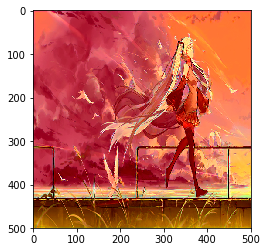

After 600 criterions:
Total loss:  499.1082763671875
Content loss:  1.496511697769165
Style loss:  274.6315002441406


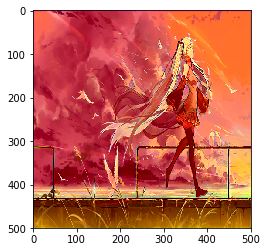

After 700 criterions:
Total loss:  469.80438232421875
Content loss:  1.3215888738632202
Style loss:  271.5660705566406


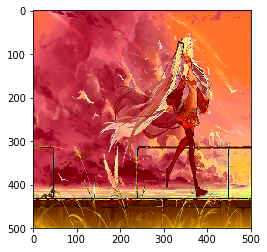

After 800 criterions:
Total loss:  458.96087646484375
Content loss:  1.266251802444458
Style loss:  269.0231018066406


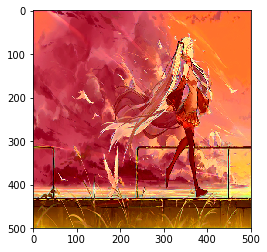

After 900 criterions:
Total loss:  447.0806884765625
Content loss:  1.2278008460998535
Style loss:  262.91058349609375


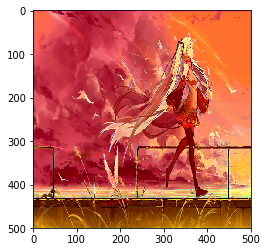

After 1000 criterions:
Total loss:  439.77716064453125
Content loss:  1.175162434577942
Style loss:  263.5027770996094


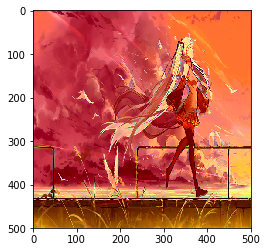

totally cost 373.56204533576965


In [9]:
time_start=time.time()
for epoch in range(0, steps+1):
    
    scheduler.step()

    target = style_net(content_image).to(device)
    target.requires_grad_(True)


    target_features = utils.get_features(target, VGG)  # extract output image's all feature maps
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0

    # compute each layer's style loss and add them
    for layer in style_weights:
        
        target_feature = target_features[layer]  # output image's feature map after layer
        target_gram_matrix = utils.get_grim_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss += layer_style_loss / (c * h * w)
    

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss_epoch.append(total_loss)

    style_loss_epoch.append(style_weight * style_loss)
    content_loss_epoch.append(content_weight * content_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % show_every == 0:
        print("After %d criterions:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('Style loss: ', style_loss.item())
        plt.imshow(utils.im_convert(target))
        plt.show()

    output_image = target
time_end=time.time()
print('totally cost', time_end - time_start)

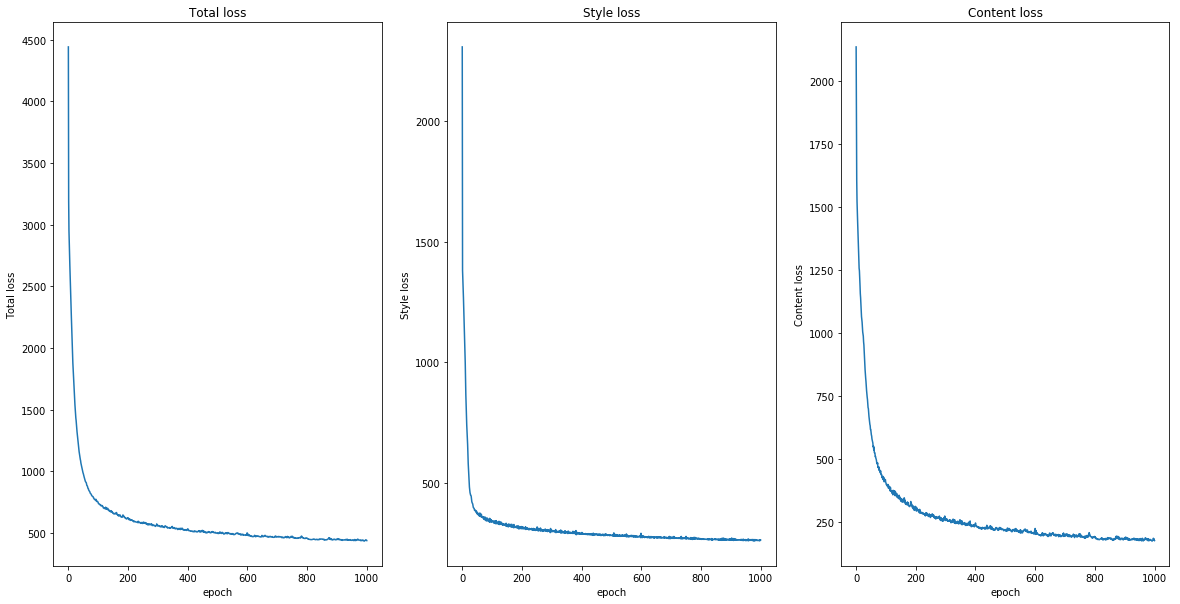

In [10]:
# plot the line chart
epoch = range(0, steps + 1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))                                                       

ax1.plot(epoch, total_loss_epoch)
ax1.set_title("Total loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("Total loss")

ax2.plot(epoch, style_loss_epoch)
ax2.set_title("Style loss")
ax2.set_xlabel("epoch")
ax2.set_ylabel("Style loss")

ax3.plot(epoch, content_loss_epoch)
ax3.set_title("Content loss")
ax3.set_xlabel("epoch")
ax3.set_ylabel("Content loss")


plt.show()

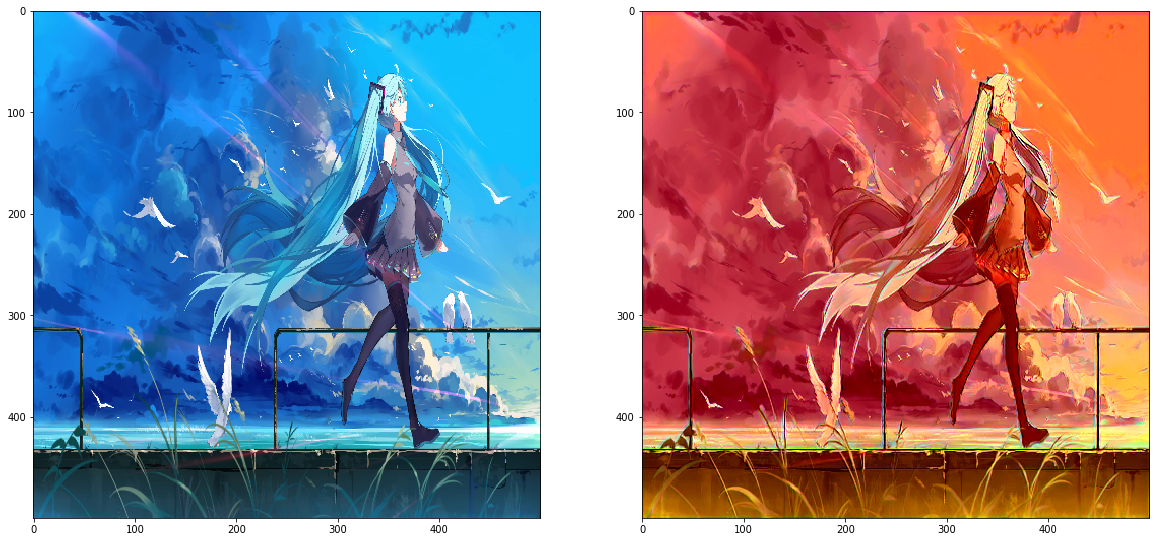

In [11]:
# display the raw images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(utils.im_convert(content_image))
ax2.imshow(utils.im_convert(output_image))
plt.show()